In [1]:
%matplotlib inline

In [2]:
%gui qt

In [3]:
import mne
import numpy as np

In [4]:
# job_arg = 8
# uncomment lines below to use CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')
job_arg = 'cuda'

# disable line below to enable interactive plots
mne.viz.set_browser_backend('matplotlib')

Using matplotlib as 2D backend.


In [5]:
# read mne-python format
raw = mne.io.read_raw_fif('../data/OBCI_10_raw.fif')
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)
raw.load_data()


Opening raw data file ../data/OBCI_10_raw.fif...
Isotrak not found
    Range : 0 ... 1024566 =      0.000 ...  1024.566 secs
Ready.
Reading 0 ... 1024566  =      0.000 ...  1024.566 secs...


<Raw | OBCI_10_raw.fif, 17 x 1024567 (1024.6 s), ~132.9 MB, data loaded>

Opening raw-browser...


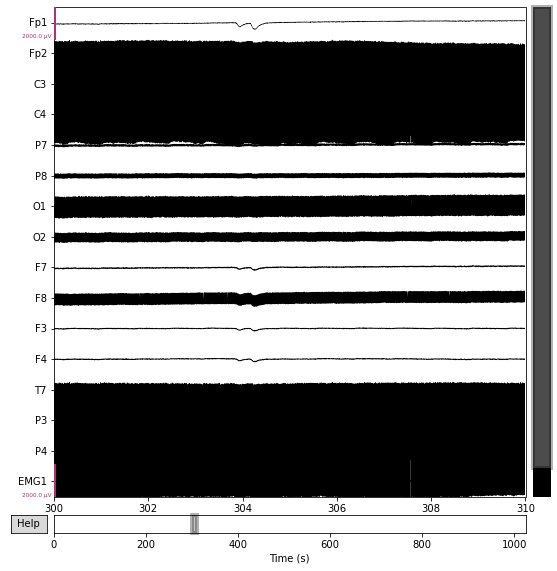

Effective window size : 2.048 (s)


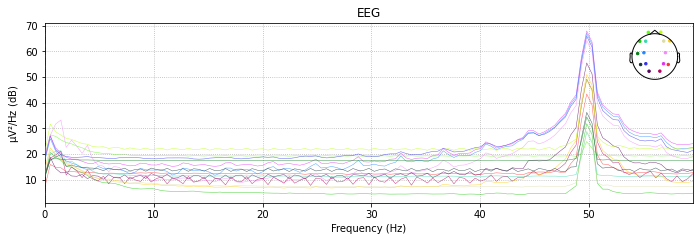

Effective window size : 2.048 (s)


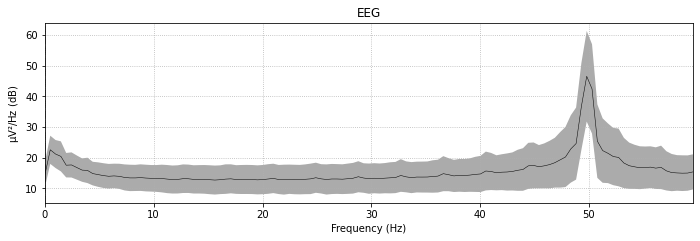

Effective window size : 2.048 (s)


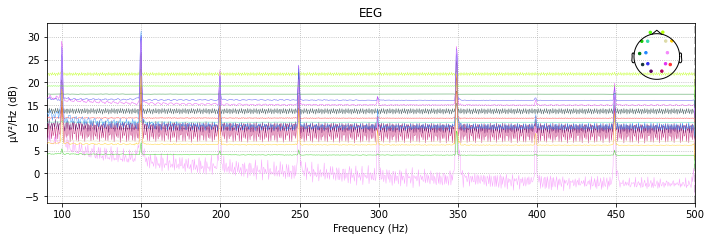

Effective window size : 2.048 (s)


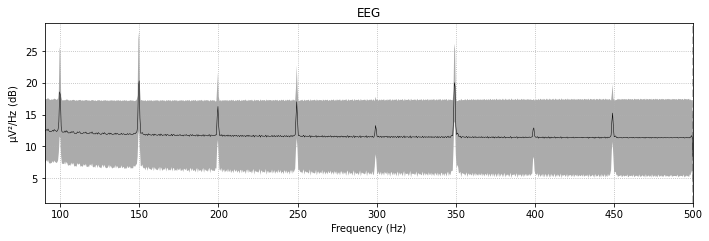

In [6]:
raw.pick_types(emg=True, eeg=True, stim=True, exclude=[])
plt = raw.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-4), theme = 'dark')
plt = raw.plot_psd(fmax=60.)
plt = raw.plot_psd(fmax=60., average=True)
plt = raw.plot_psd(fmin=90., fmax=500.0)
plt = raw.plot_psd(fmin=90., fmax=500., average=True)

before doing the other method let's try a different way to detect / filter bad stuff

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Now using CUDA device 0
Enabling CUDA with 7.06 GB available memory
Using CUDA for FFT FIR filtering
Effective window size : 2.048 (s)


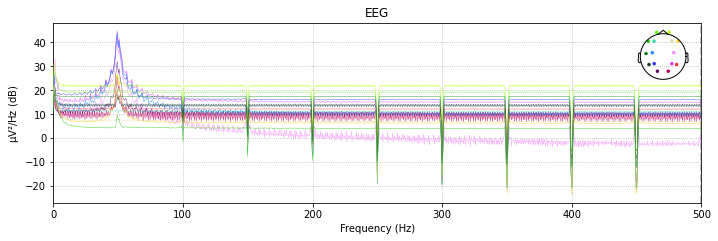

Effective window size : 2.048 (s)


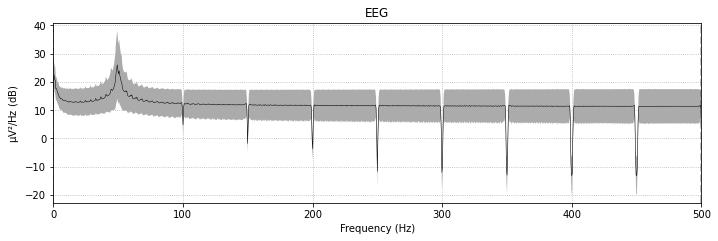

Effective window size : 2.048 (s)


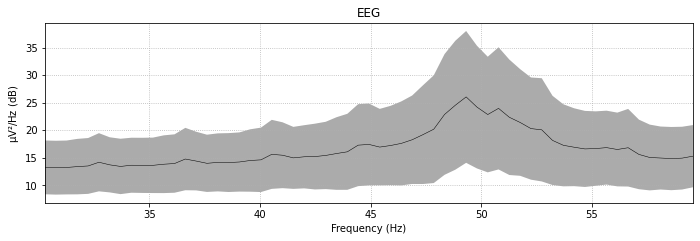

In [7]:
freqs = np.arange(50., 451., 50.)
#notch_widths = freqs/200.
#notch_widths[0] = 10.

#print(notch_widths)

raw_notch = raw.copy().notch_filter(freqs, picks = ['eeg'],  n_jobs=job_arg)
# spectrum fit doesn't support cuda
#raw_notch = raw.copy().notch_filter(freqs, method='spectrum_fit', picks = ['eeg'], n_jobs=8, filter_length='8s')
raw_notch.plot_psd()
raw_notch.plot_psd(average=True)
raw_notch.plot_psd(fmin=30., fmax=60., average=True)
event_ids = {
    'left': ord('l'),
    'right': ord('r'),
    'neutral': ord('n'),
    'fixation': ord('f'),
    'ready': ord('k'),
}



Opening raw-browser...


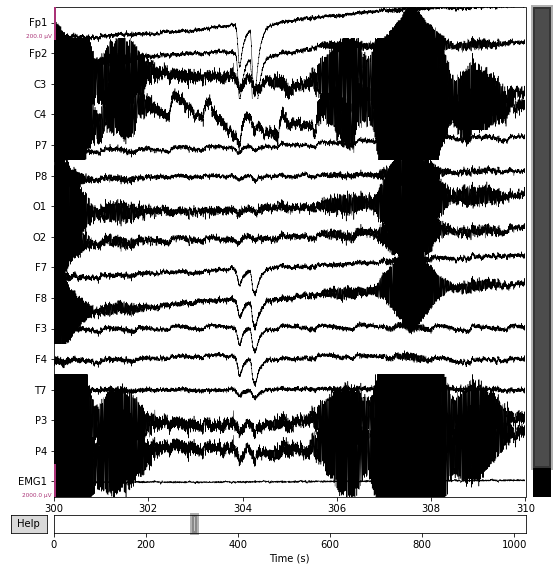

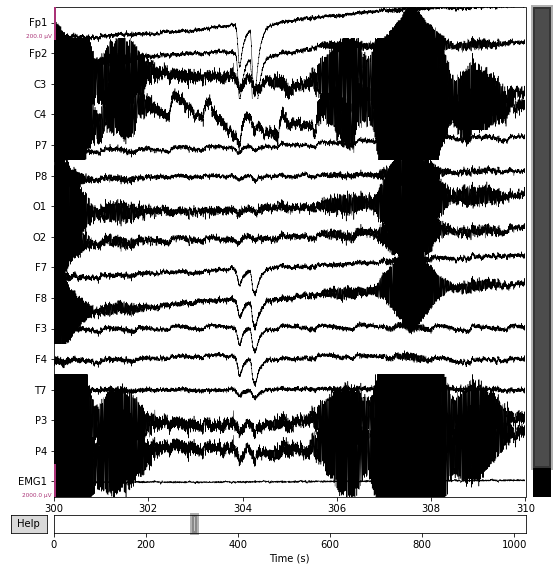

In [8]:
raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark')

https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html
Best practices
To avoid the reduction in temporal precision of events that comes with resampling a Raw object, and also avoid the edge artifacts that come with filtering an Epochs or Evoked object, the best practice is to:

low-pass filter the Raw data at or below 
 
 of the desired sample rate, then

decimate the data after epoching, by either passing the decim parameter to the Epochs constructor, or using the decimate() method after the Epochs have been created.

Warning

The recommendation for setting the low-pass corner frequency at 
 
 of the desired sample rate is a fairly safe rule of thumb based on the default settings in raw.filter() (which are different from the filter settings used inside the raw.resample() method). If you use a customized lowpass filter (specifically, if your transition bandwidth is wider than 0.5× the lowpass cutoff), downsampling to 3× the lowpass cutoff may still not be enough to avoid aliasing, and MNE-Python will not warn you about it (because the raw.info object only keeps track of the lowpass cutoff, not the transition bandwidth). Conversely, if you use a steeper filter, the warning may be too sensitive. If you are unsure, plot the PSD of your filtered data before decimating and ensure that there is no content in the frequencies above the Nyquist frequency of the sample rate you’ll end up with after decimation.


while inspecting this waveform an idea came to me that it might be fun to try and make a point cloud out of the data, using coordinates eg sample sequence=time, channel = color, channel data / waveform = x,y,decim=z

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 330001 samples (330.001 sec)

Using CUDA for FFT FIR filtering
262 events found
Event IDs: [ 53 102 107 108 110 114]
Using CUDA for FFT resampling
Trigger channel has a non-zero initial value of 102 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
261 events found
Event IDs: [ 53 102 107 108 110 114]
Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:4: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw_notch_ds = raw_notch.copy().resample(sfreq=250., n_jobs=job_arg)


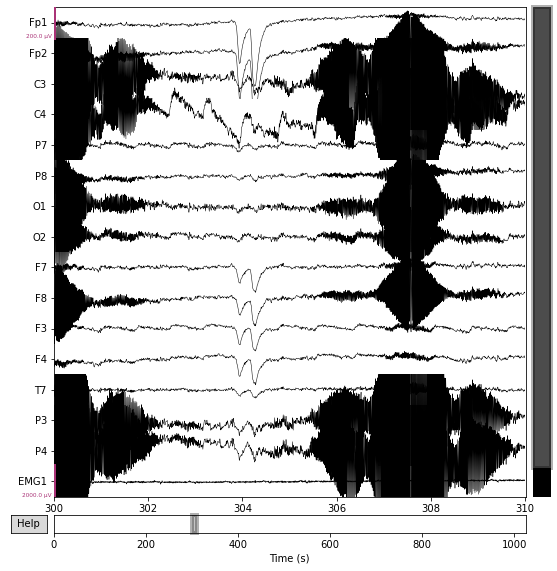

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:6: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=10 parameter will result in a sampling frequency of 25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)


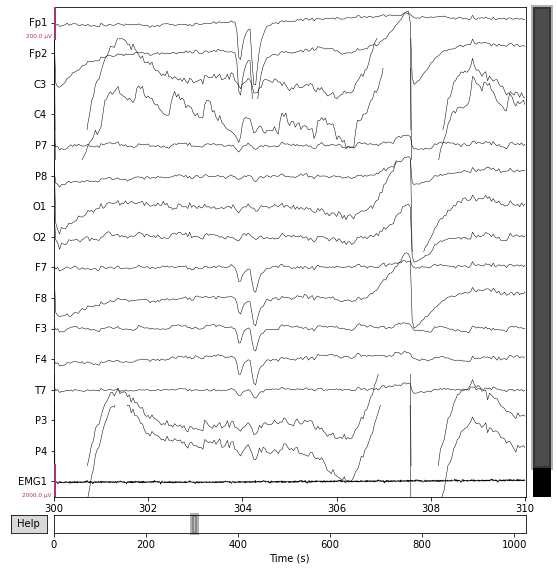

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:7: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=20 parameter will result in a sampling frequency of 12.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)


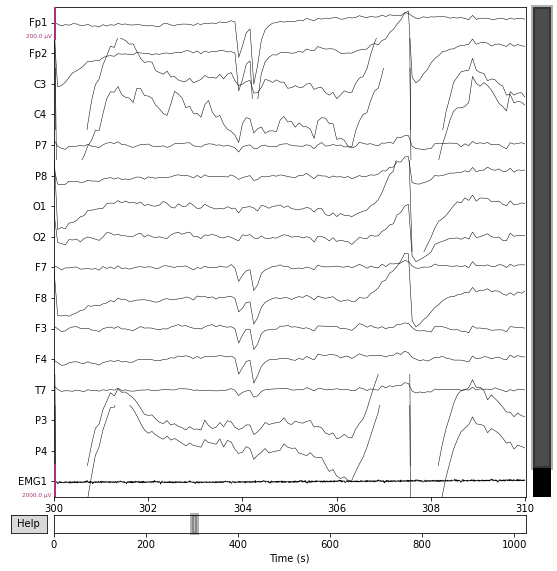

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:8: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=100 parameter will result in a sampling frequency of 2.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)


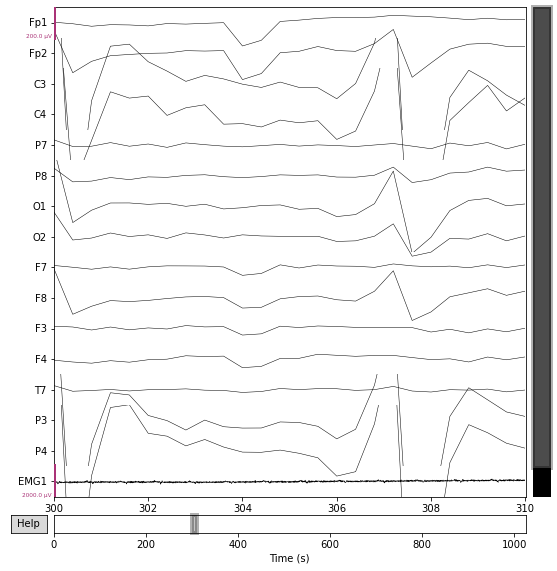

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:9: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=1000 parameter will result in a sampling frequency of 0.25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)


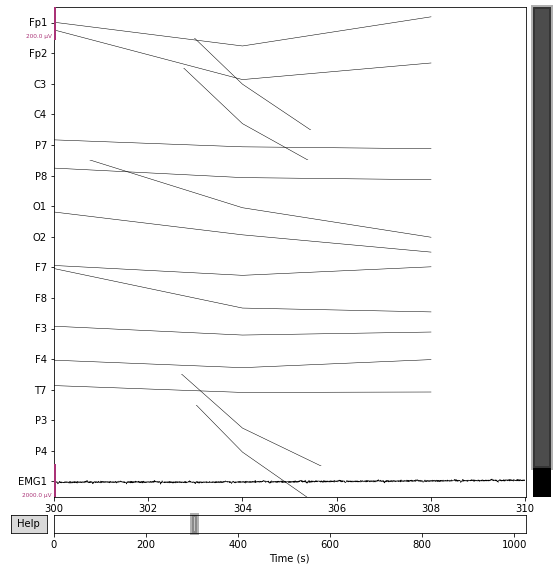

Opening raw-browser...


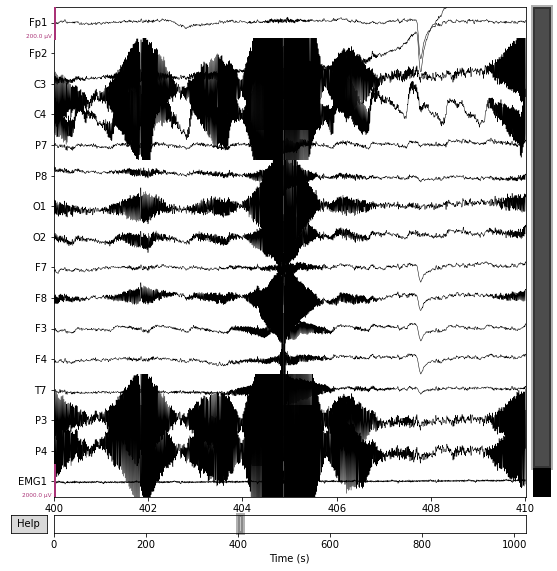

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:12: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=10 parameter will result in a sampling frequency of 25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)


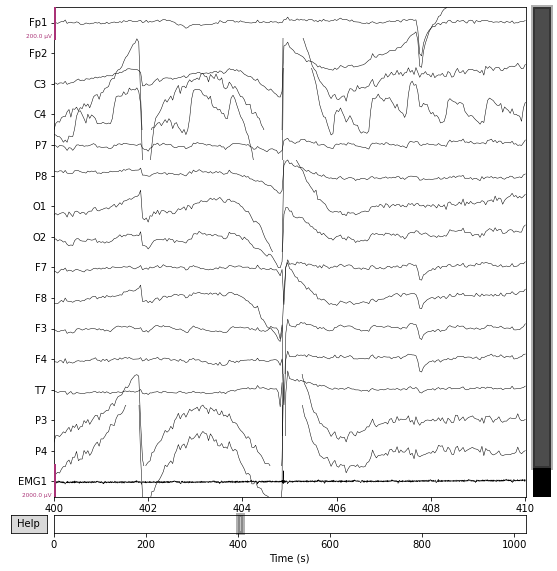

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:13: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=20 parameter will result in a sampling frequency of 12.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)


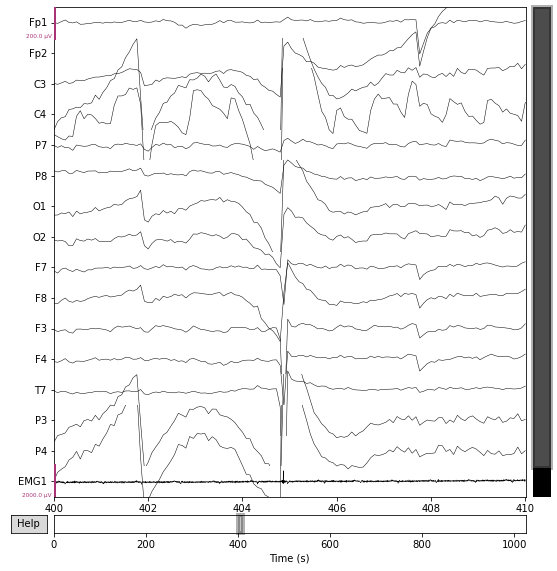

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:14: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=100 parameter will result in a sampling frequency of 2.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)


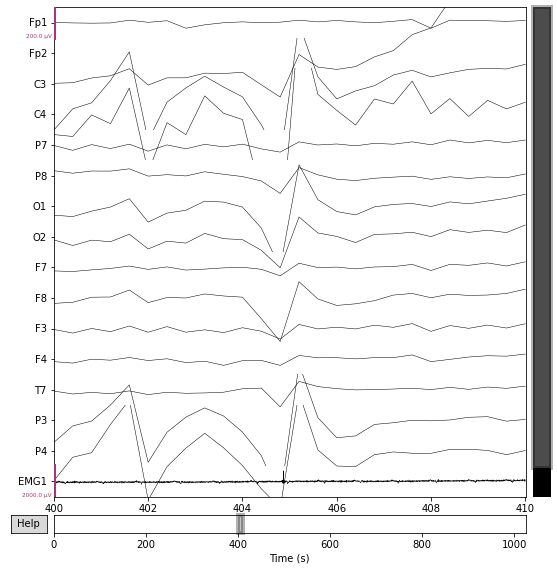

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:15: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=1000 parameter will result in a sampling frequency of 0.25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)


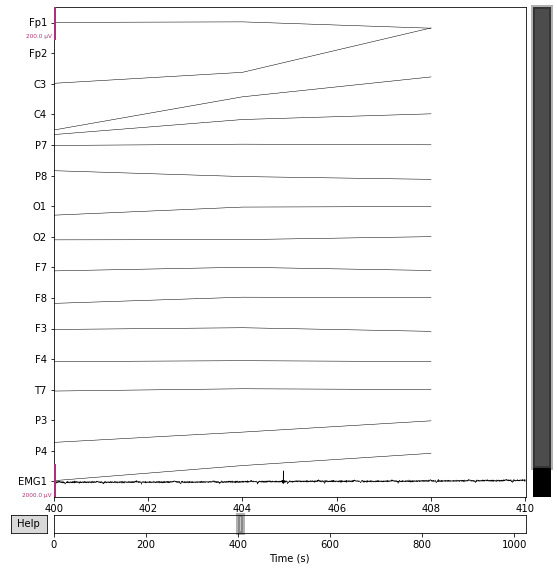

Opening raw-browser...


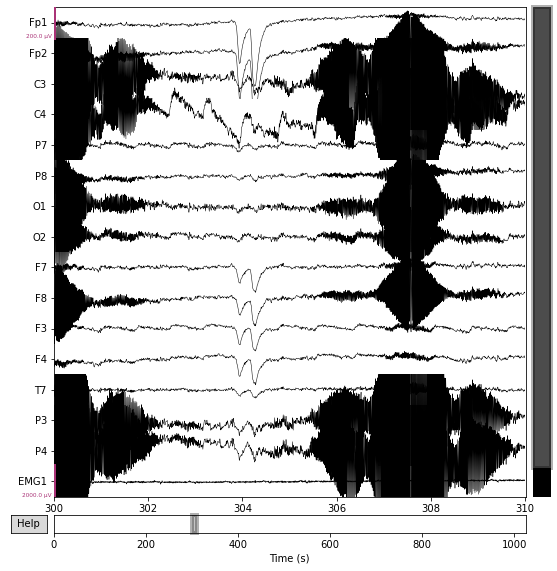

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:18: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=10 parameter will result in a sampling frequency of 25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)


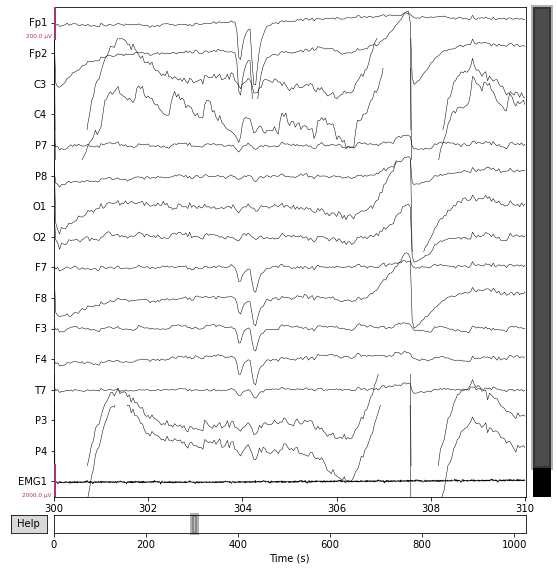

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:19: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=20 parameter will result in a sampling frequency of 12.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)


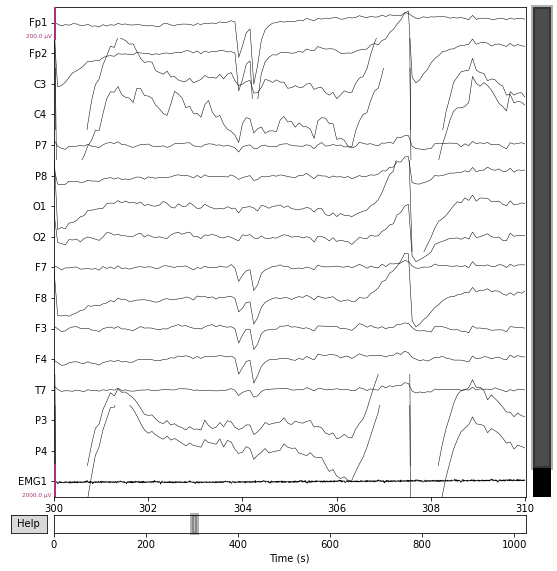

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:20: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=100 parameter will result in a sampling frequency of 2.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)


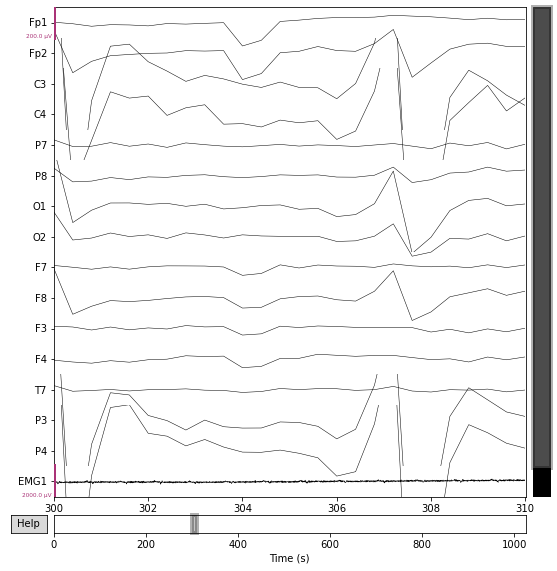

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:21: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=1000 parameter will result in a sampling frequency of 0.25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)


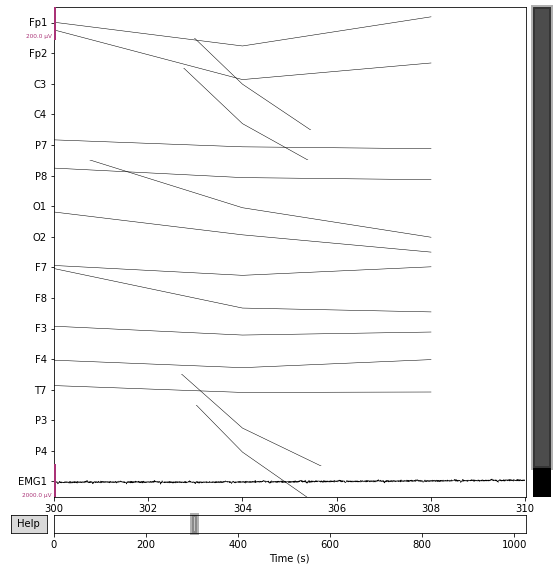

Opening raw-browser...


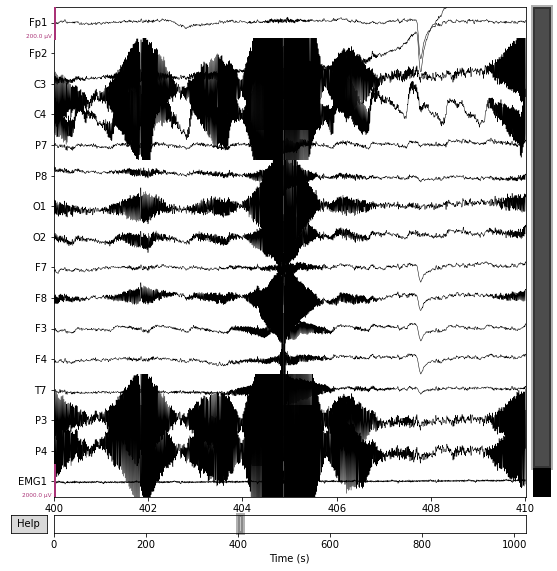

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:24: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=10 parameter will result in a sampling frequency of 25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)


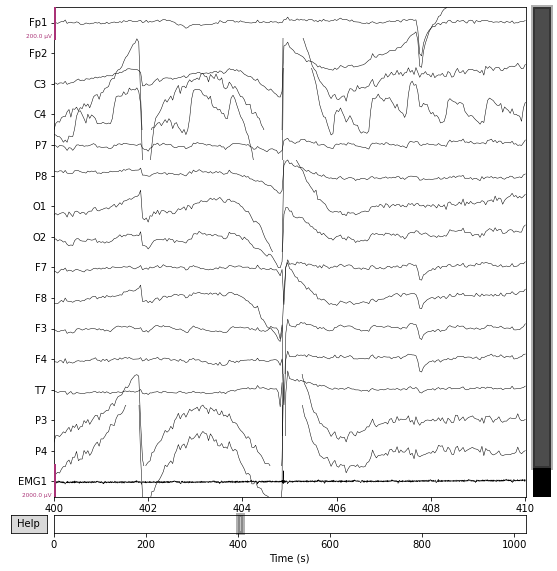

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:25: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=20 parameter will result in a sampling frequency of 12.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)


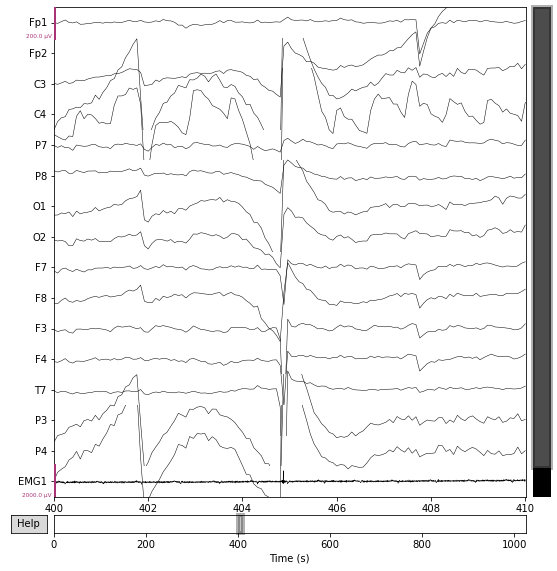

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:26: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=100 parameter will result in a sampling frequency of 2.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)


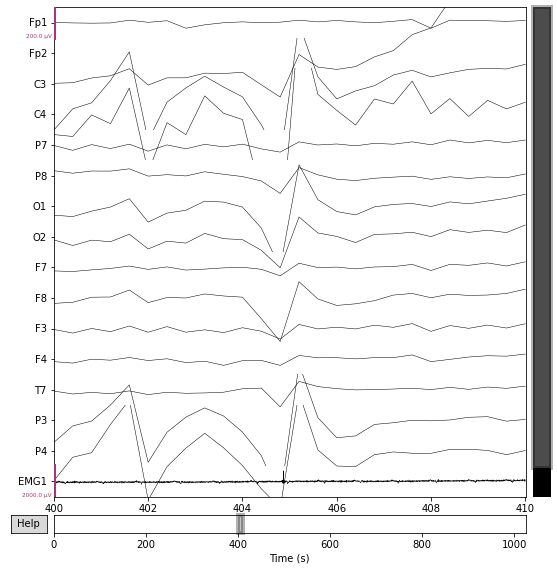

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:27: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=1000 parameter will result in a sampling frequency of 0.25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)


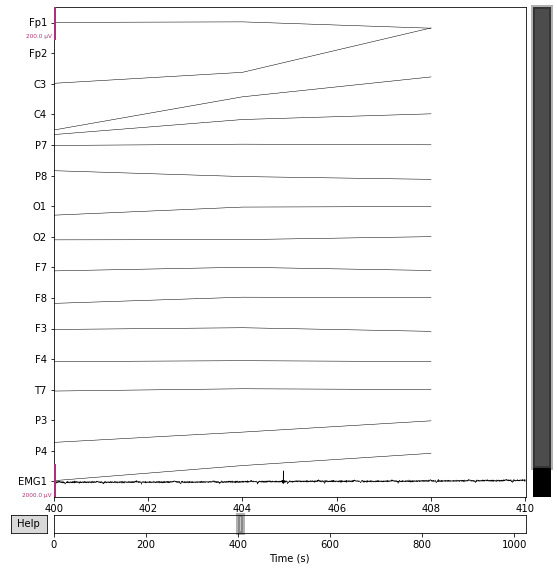

Opening raw-browser...


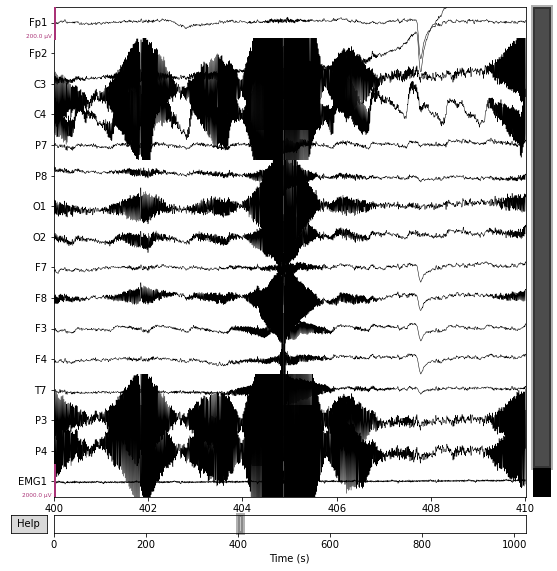

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:30: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=10 parameter will result in a sampling frequency of 25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)


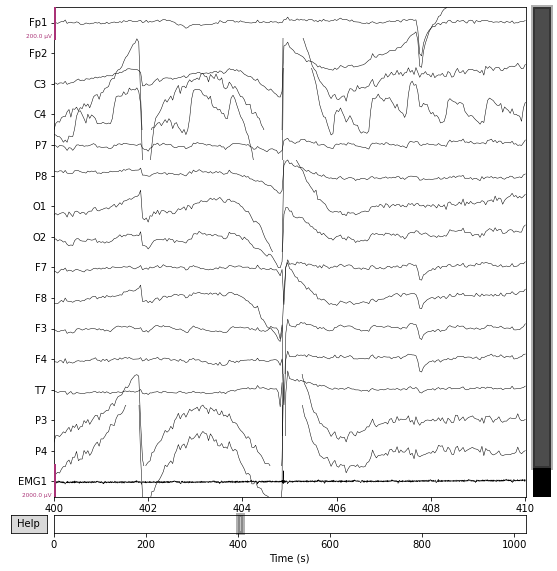

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:31: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=20 parameter will result in a sampling frequency of 12.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)


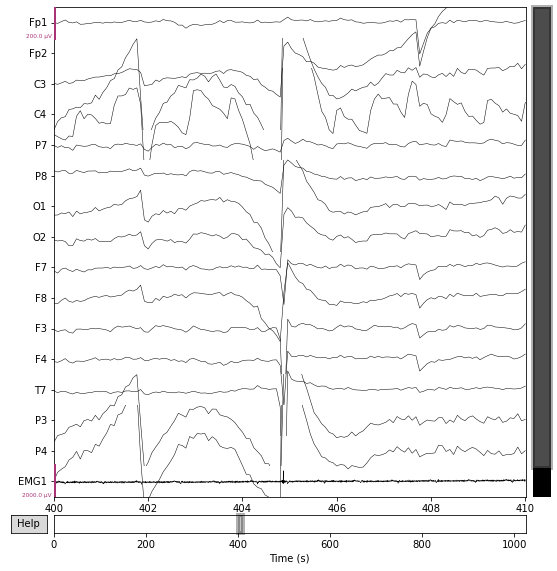

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:32: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=100 parameter will result in a sampling frequency of 2.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)


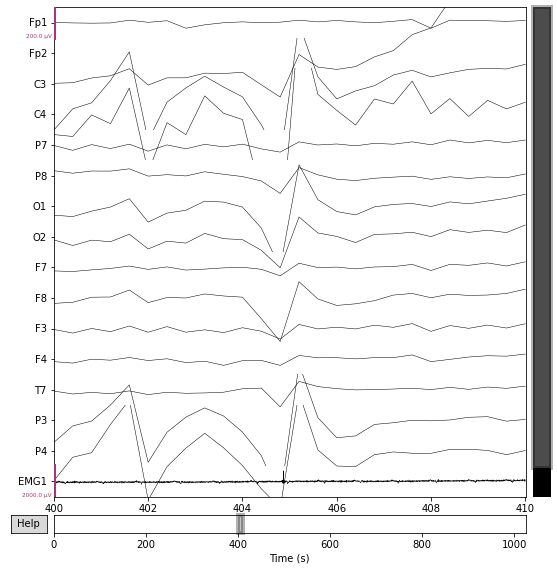

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:33: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=1000 parameter will result in a sampling frequency of 0.25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)


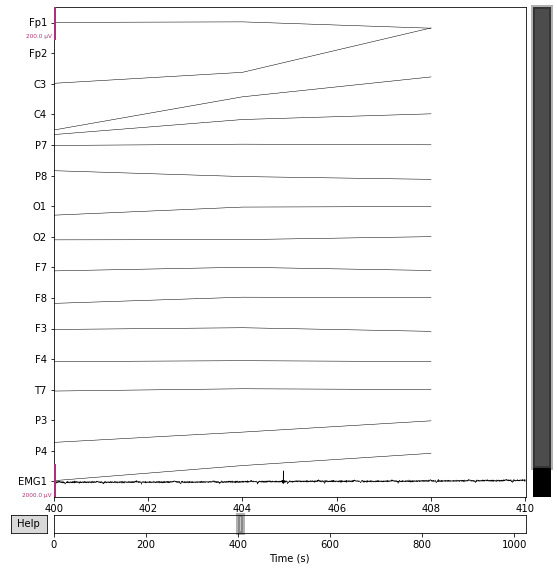

Opening raw-browser...


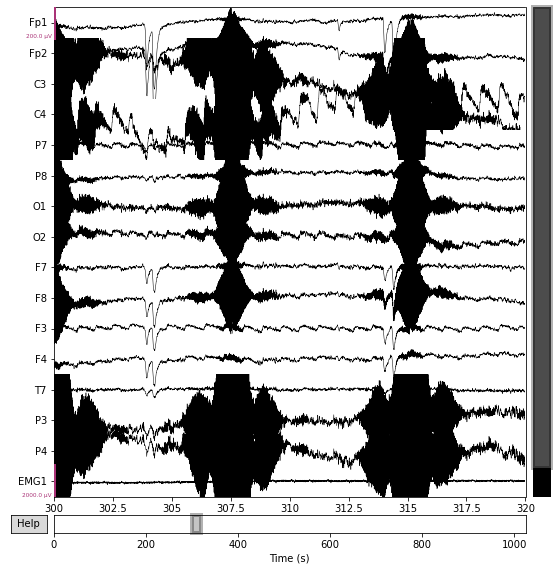

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:36: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=10 parameter will result in a sampling frequency of 25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)


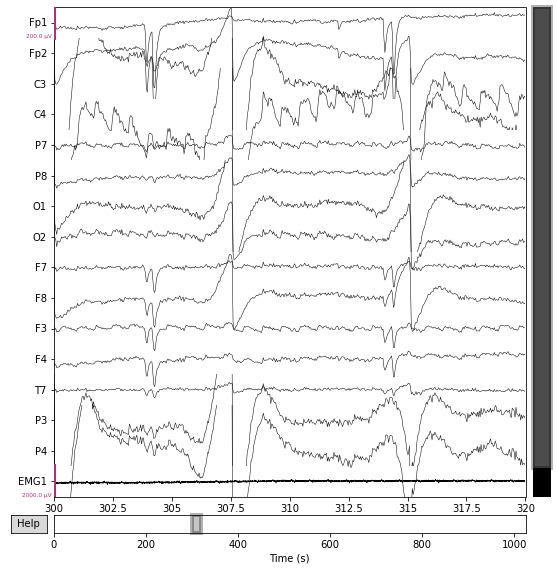

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:37: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=20 parameter will result in a sampling frequency of 12.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)


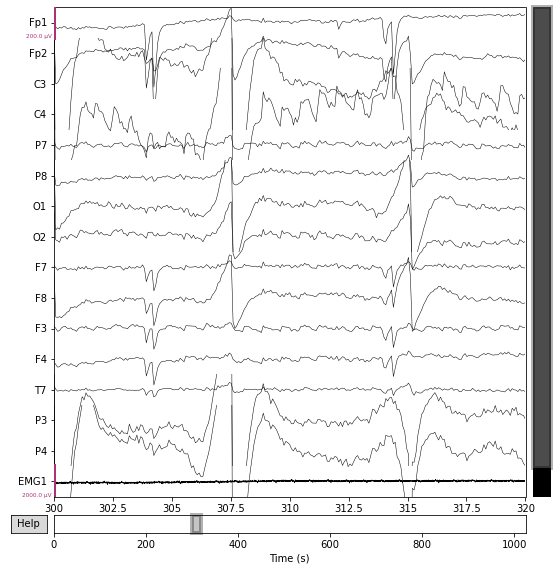

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=100 parameter will result in a sampling frequency of 2.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)


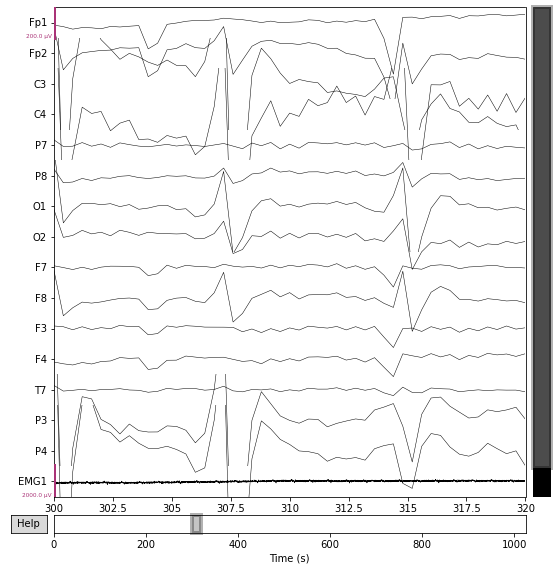

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:39: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=1000 parameter will result in a sampling frequency of 0.25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)


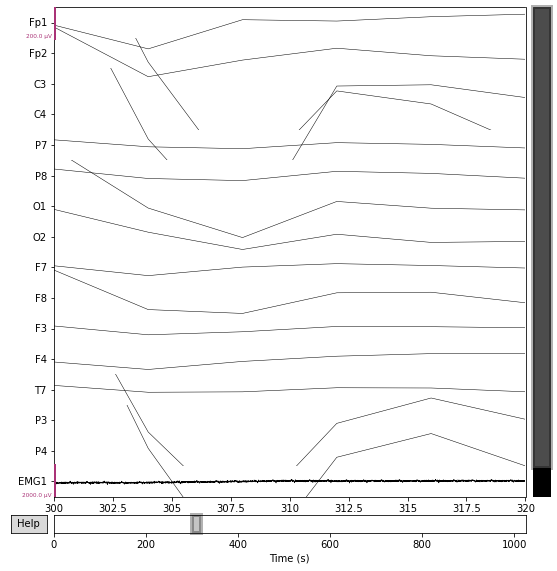

Opening raw-browser...


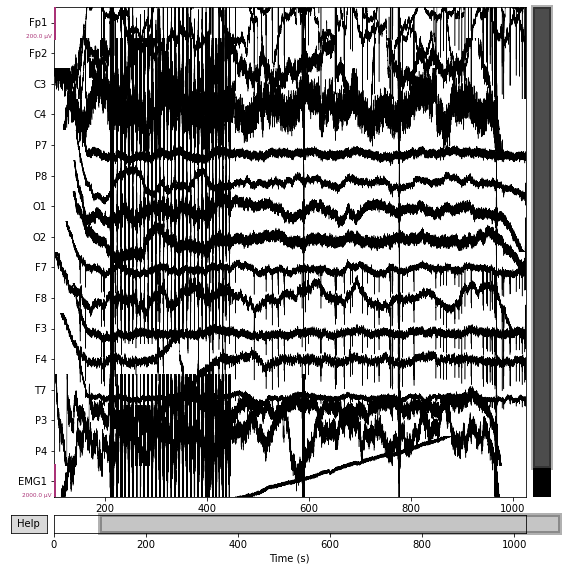

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:42: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=10 parameter will result in a sampling frequency of 25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 100, duration = 1000, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)


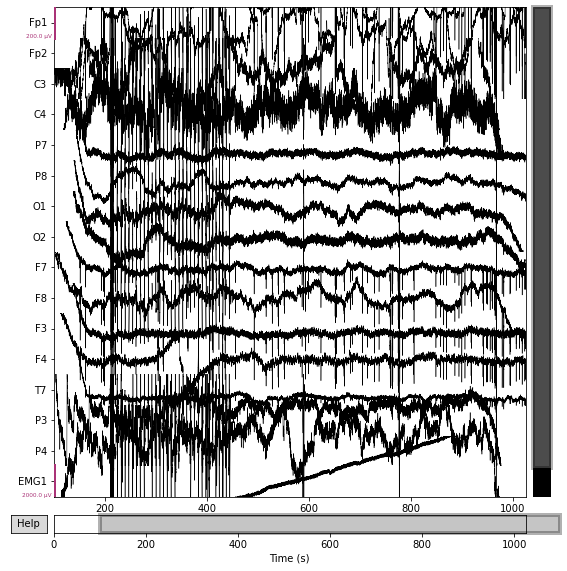

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:43: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=20 parameter will result in a sampling frequency of 12.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 100, duration = 1000, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)


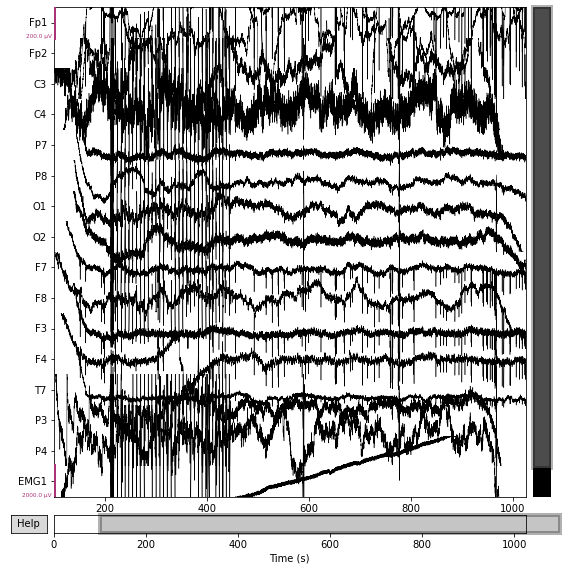

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:44: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=100 parameter will result in a sampling frequency of 2.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 100, duration = 1000, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)


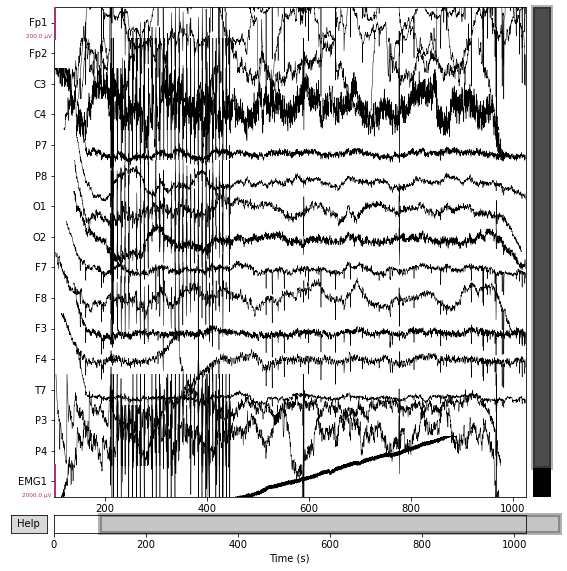

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:45: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=1000 parameter will result in a sampling frequency of 0.25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 100, duration = 1000, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)


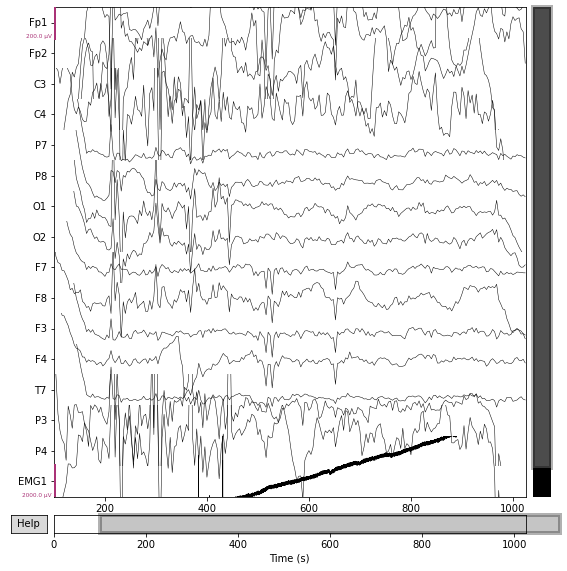

Opening raw-browser...


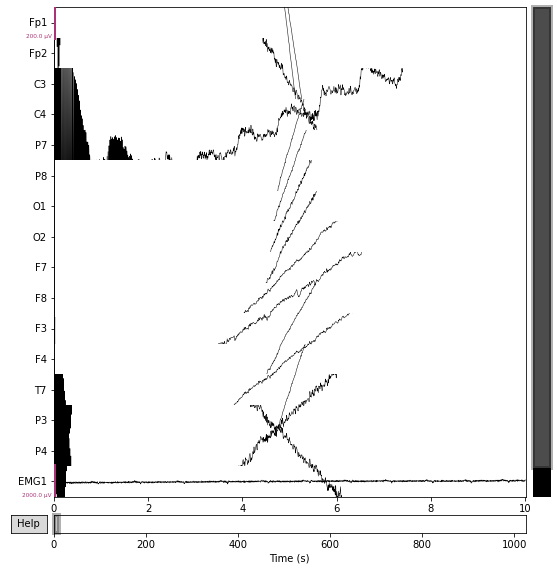

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:48: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=10 parameter will result in a sampling frequency of 25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 0, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)


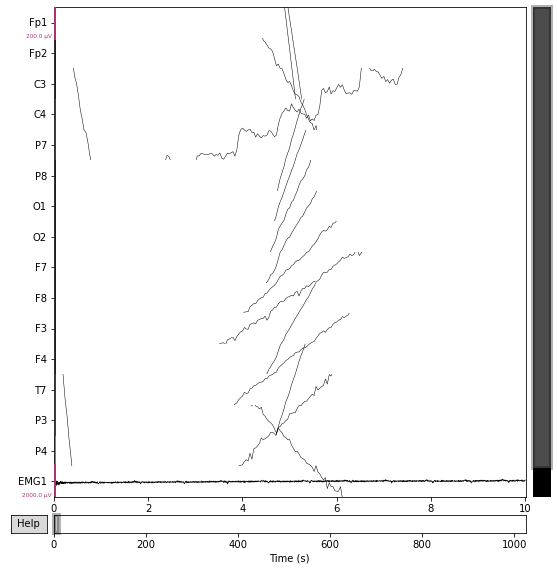

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:49: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=20 parameter will result in a sampling frequency of 12.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 0, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)


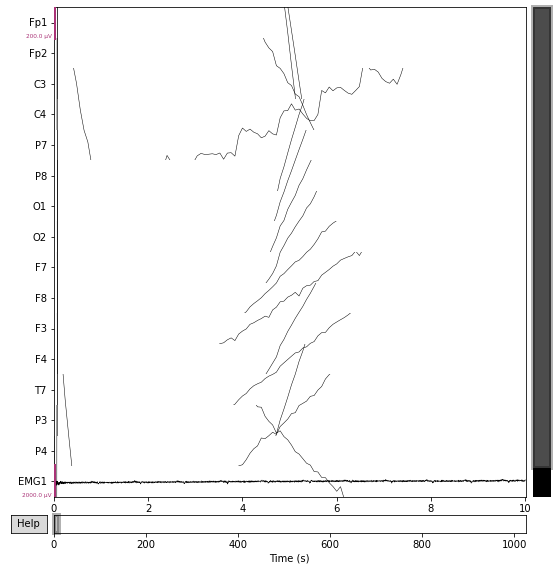

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:50: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=100 parameter will result in a sampling frequency of 2.5 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 0, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)


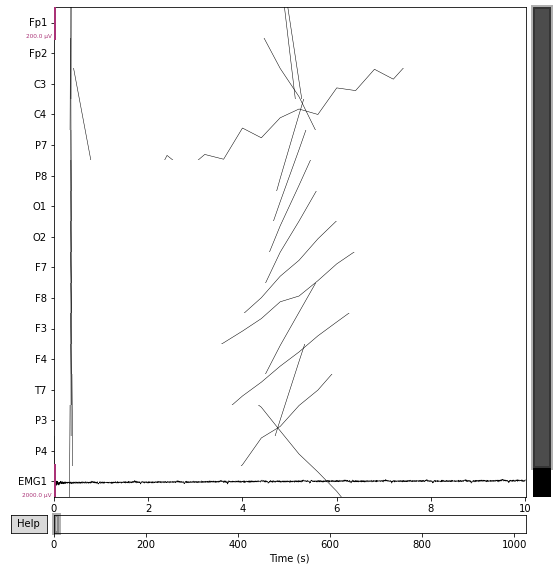

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_26644\3989072949.py:51: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=1000 parameter will result in a sampling frequency of 0.25 Hz, which can cause aliasing artifacts.
  plt = raw_notch_ds.plot(n_channels = 16, start = 0, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)


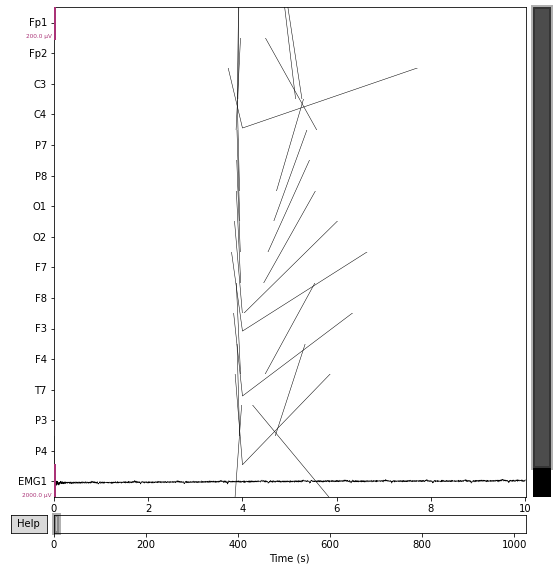

In [9]:
decim = 4

raw_notch.filter(l_freq=0.01, h_freq=49., n_jobs=job_arg)
raw_notch_ds = raw_notch.copy().resample(sfreq=250., n_jobs=job_arg)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark')
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)

plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark')
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)

plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark')
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)

plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark')
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)

plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark')
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)
plt = raw_notch_ds.plot(n_channels = 16, start = 400, duration = 10, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)

plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark')
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)
plt = raw_notch_ds.plot(n_channels = 16, start = 300, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)

plt = raw_notch_ds.plot(n_channels = 16, start = 100, duration = 1000, scalings = dict(eeg = 10e-5), theme = 'dark')
plt = raw_notch_ds.plot(n_channels = 16, start = 100, duration = 1000, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)
plt = raw_notch_ds.plot(n_channels = 16, start = 100, duration = 1000, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)
plt = raw_notch_ds.plot(n_channels = 16, start = 100, duration = 1000, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)
plt = raw_notch_ds.plot(n_channels = 16, start = 100, duration = 1000, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)

plt = raw_notch_ds.plot(n_channels = 16, start = 0, scalings = dict(eeg = 10e-5), theme = 'dark')
plt = raw_notch_ds.plot(n_channels = 16, start = 0, scalings = dict(eeg = 10e-5), theme = 'dark', decim=10)
plt = raw_notch_ds.plot(n_channels = 16, start = 0, scalings = dict(eeg = 10e-5), theme = 'dark', decim=20)
plt = raw_notch_ds.plot(n_channels = 16, start = 0, scalings = dict(eeg = 10e-5), theme = 'dark', decim=100)
plt = raw_notch_ds.plot(n_channels = 16, start = 0, scalings = dict(eeg = 10e-5), theme = 'dark', decim=1000)


In [10]:
# tbc...i think with a numpy array to 3d points, you could then just scale any axis, etc

In [11]:
events = mne.find_events(raw_notch_ds)
epochs = mne.Epochs(raw_notch_ds, events, event_id=event_ids['right'], preload=True)



Trigger channel has a non-zero initial value of 102 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
261 events found
Event IDs: [ 53 102 107 108 110 114]
Not setting metadata
29 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 176 original time points ...
0 bad epochs dropped


or create a bipolar reference from frontal EEG sensors and use that as virtual EOG channel. This carries a risk however: you must hope that the frontal EEG channels only reflect EOG and not brain dynamics in the prefrontal cortex (or you must not care about those prefrontal signals).

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=256142
    Range : 0 ... 256141 =      0.000 ...  1024.564 secs
Ready.
Added the following bipolar channels:
Fp1-Fp2
Opening raw-browser...


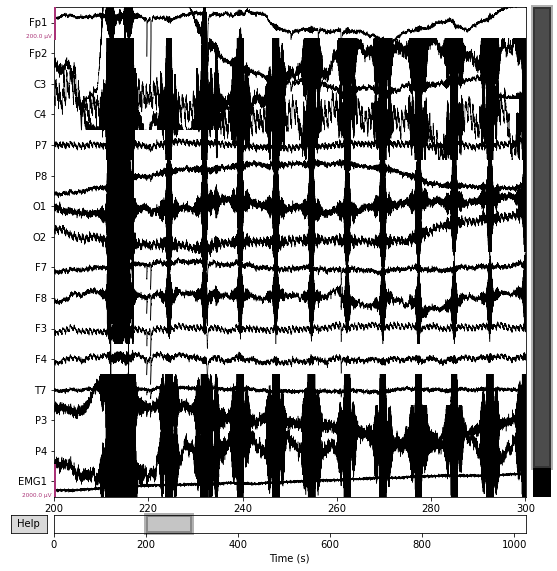

Opening raw-browser...


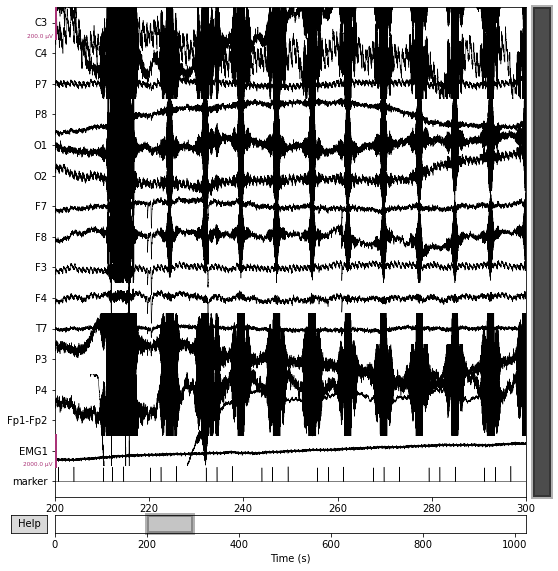

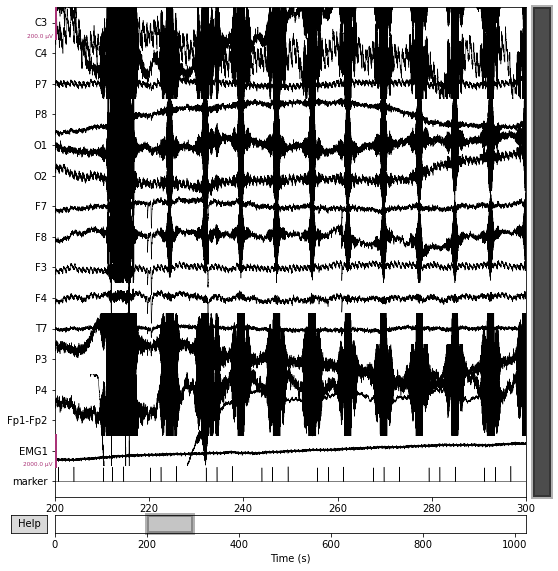

In [12]:
# let's try
raw_bip_ref = mne.set_bipolar_reference(raw_notch_ds, anode=['Fp1'],
                                        cathode=['Fp2'])

raw_notch_ds.plot(n_channels = 16, start = 200, duration = 100, scalings = dict(eeg = 10e-5), theme = 'dark')
raw_bip_ref.plot(n_channels = 16, start = 200, duration = 100, scalings = dict(eeg = 10e-5), theme = 'dark')

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 5.2s.
Using EOG channel: Fp1-Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition 

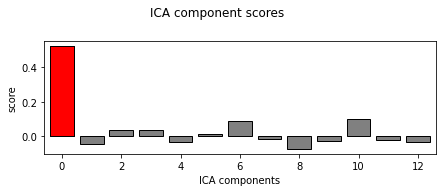

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
512 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


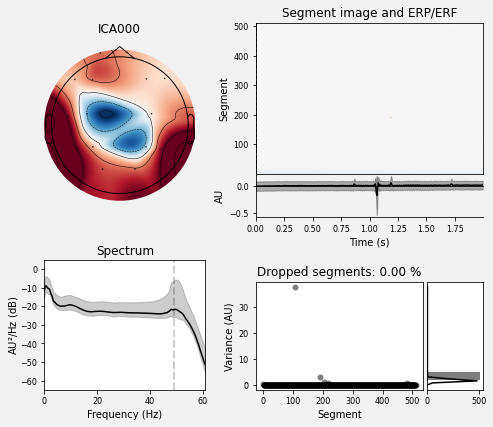

Creating RawArray with float64 data, n_channels=13, n_times=256142
    Range : 0 ... 256141 =      0.000 ...  1024.564 secs
Ready.
Opening ica-browser...


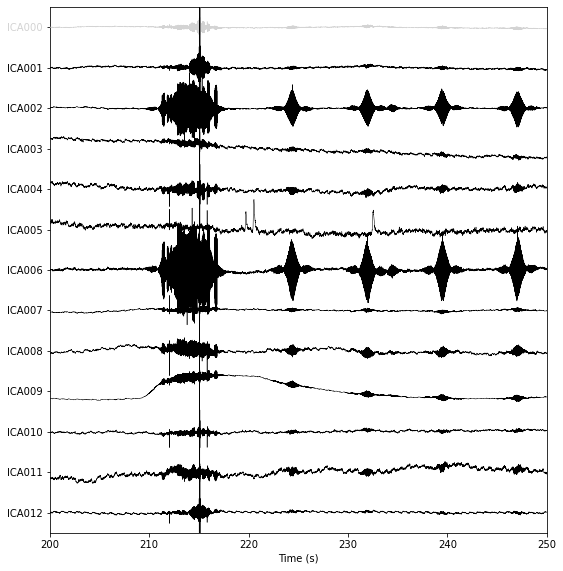

In [13]:
# epochs.set_eeg_reference('average', projection=True)
# epochs.apply_proj()
# _, betas = mne.preprocessing.regress_artifact(epochs.copy().subtract_evoked(), picks = 'eeg', picks_artifact="EMG1")
# epochs_clean, _ = mne.preprocessing.regress_artifact(epochs, betas=betas, picks = 'eeg', picks_artifact="EMG1")
# fig = epochs.average(picks=['eeg']).plot(picks=['eeg', 'EMG1'], exclude=[], spatial_colors=True, ylim=dict(EMG1=[-35, 5], eeg=[-350, 300]))

# fig = epochs_clean.average(picks=['eeg']).plot(picks=['eeg', 'EMG1'], exclude=[], spatial_colors=True, ylim=dict(EMG1=[-35, 5], eeg=[-350, 300]))

# the stuff above doesn't really work given no EOG channel. instead...


# eog_evoked = mne.preprocessing.create_eog_epochs(raw_bip_ref, ch_name='Fp1-Fp2').average()
# eog_evoked.plot_joint()

ica = mne.preprocessing.ICA(n_components=None, max_iter=1000, method='picard')
ica.exclude = []

ica.fit(raw_bip_ref, picks=['eeg'])
ica

eeg_indices, eeg_score = ica.find_bads_eog(raw_bip_ref, ch_name='Fp1-Fp2', threshold='auto')

ica.exclude = eeg_indices

# barplot of ICA component "ECG match" scores
plt = ica.plot_scores(eeg_score)

# plot diagnostics
plt = ica.plot_properties(raw_bip_ref, picks=eeg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
plt = ica.plot_sources(raw_bip_ref, show_scrollbars=False, start=200, stop=250)

# # plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
# ica.plot_sources(eog_evoked)



ica 2 and 6 also look like the worst offenders

Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components


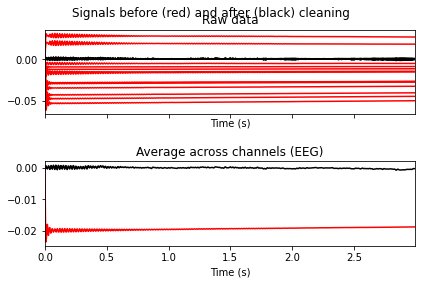

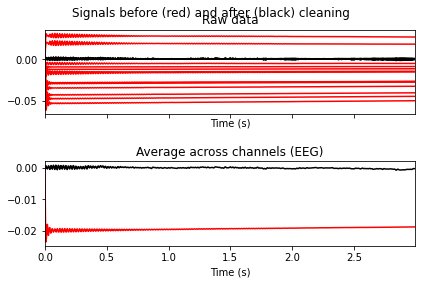

In [14]:
ica.plot_overlay(raw_bip_ref, exclude=[0,2,6], picks='eeg')


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
512 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
512 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
512 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


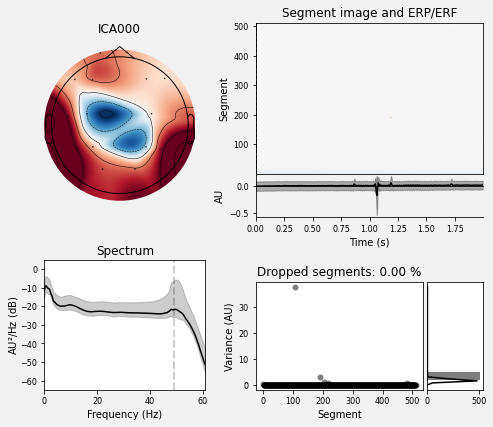

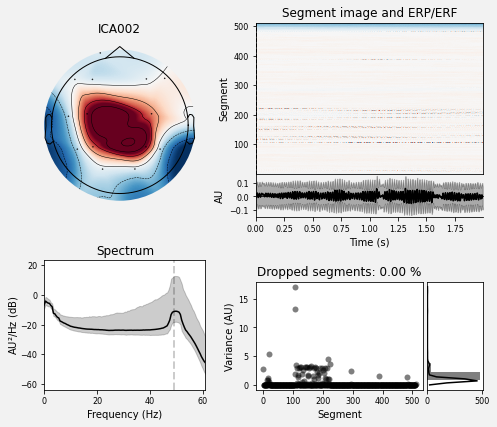

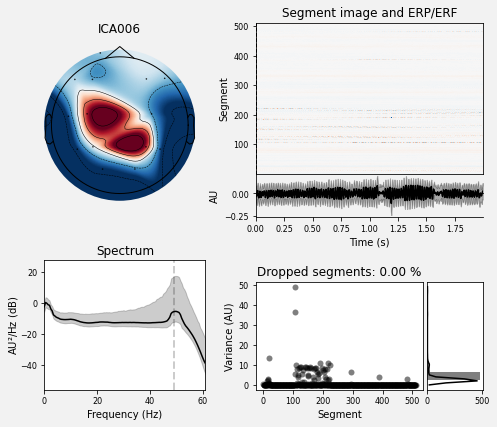

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [15]:
ica.plot_properties(raw_bip_ref, picks=[0, 2, 6])

In [16]:
ica.exclude = [0, 2, 6]

Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
Opening raw-browser...


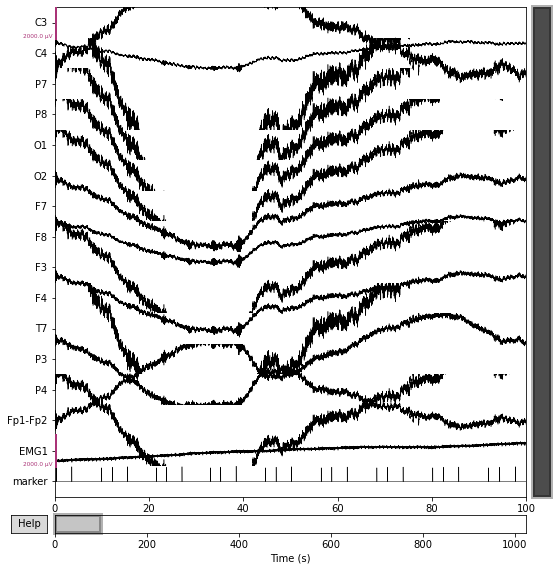

Opening raw-browser...


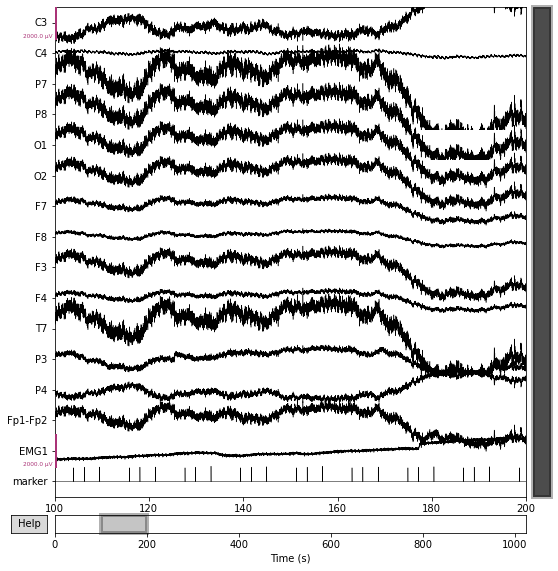

Opening raw-browser...


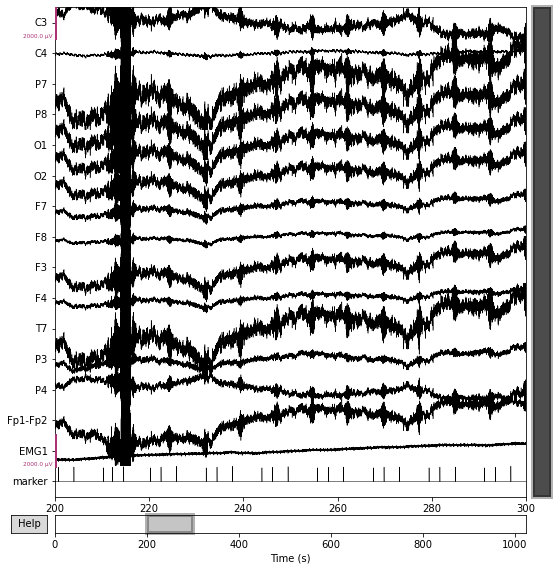

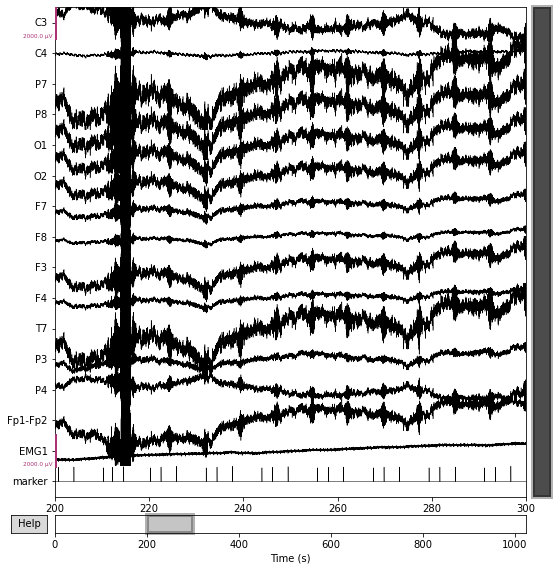

In [17]:
raw_notch_ds_reconst = raw_bip_ref.copy()
ica.apply(raw_notch_ds_reconst)

raw_notch_ds_reconst.plot(n_channels = 16, start = 0, duration = 100, scalings = dict(eeg = 10e-4), theme = 'dark')
raw_notch_ds_reconst.plot(n_channels = 16, start = 100, duration = 100, scalings = dict(eeg = 10e-4), theme = 'dark')
raw_notch_ds_reconst.plot(n_channels = 16, start = 200, duration = 100, scalings = dict(eeg = 10e-4), theme = 'dark')


Opening raw-browser...


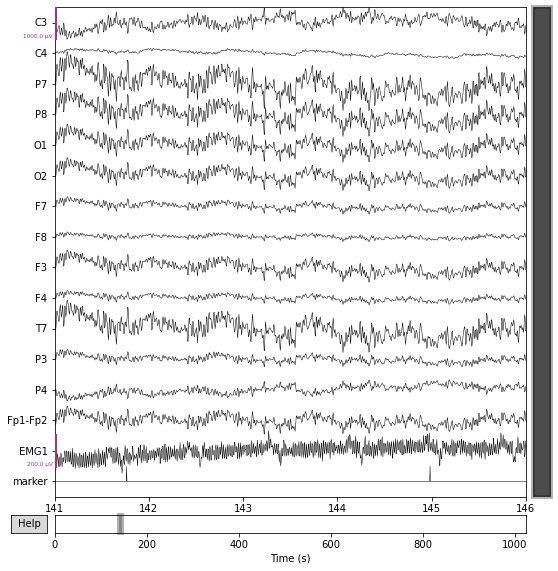

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Opening raw-browser...


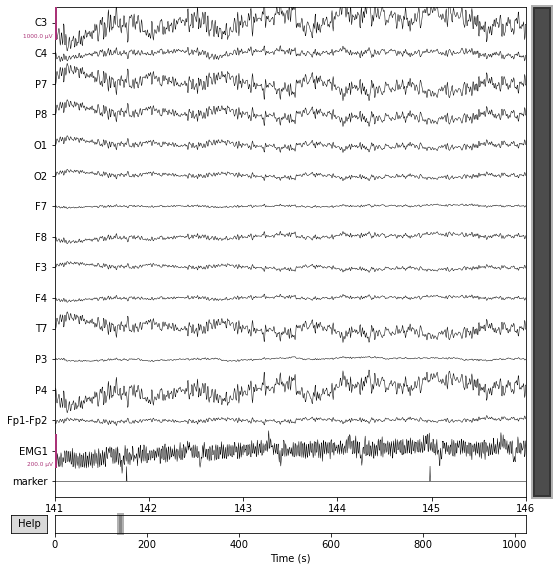

In [18]:
plt = raw_notch_ds_reconst.plot(n_channels = 16, start = 141, duration = 5, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')
raw_avg_ref = raw_notch_ds_reconst.copy().set_eeg_reference(ref_channels='average')
plt = raw_avg_ref.plot(n_channels = 16, start = 141, duration = 5, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Opening raw-browser...


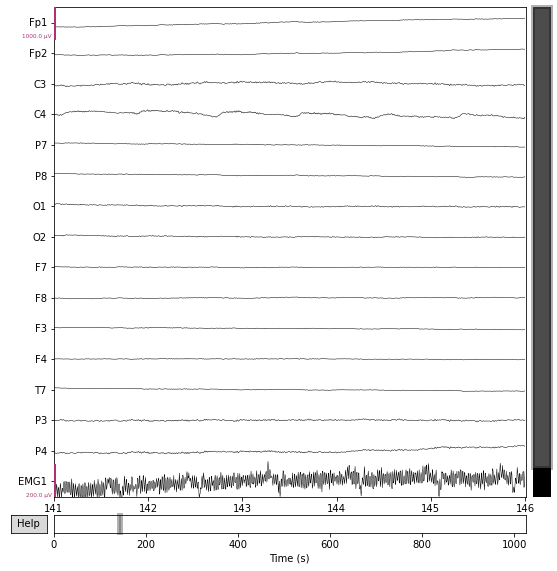

Opening raw-browser...


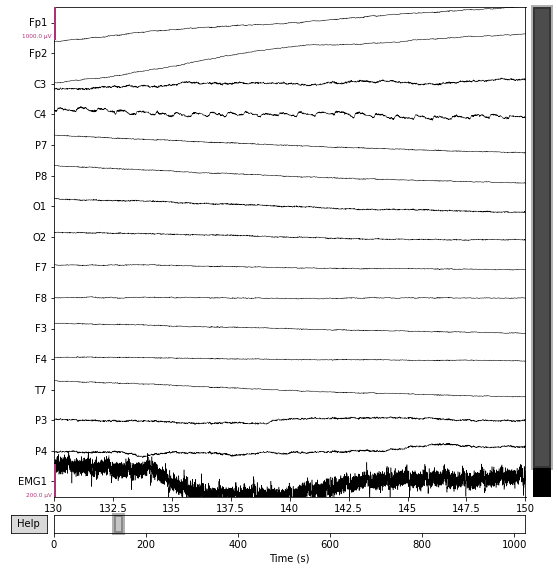

Opening raw-browser...


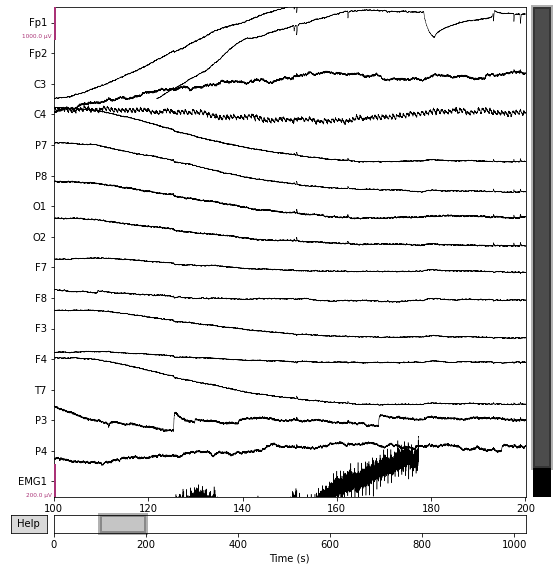

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Opening raw-browser...


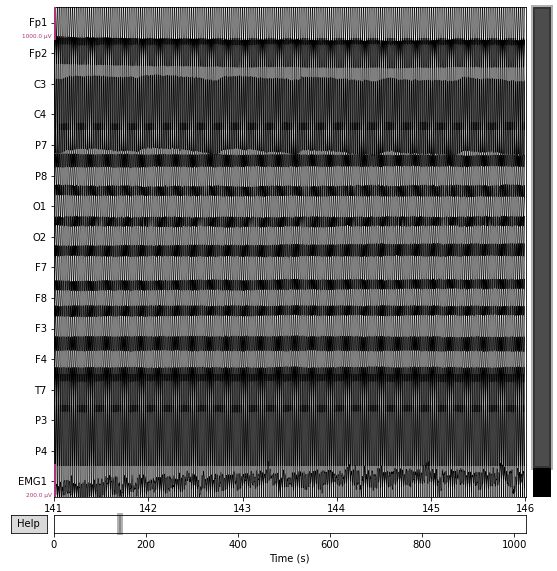

Opening raw-browser...


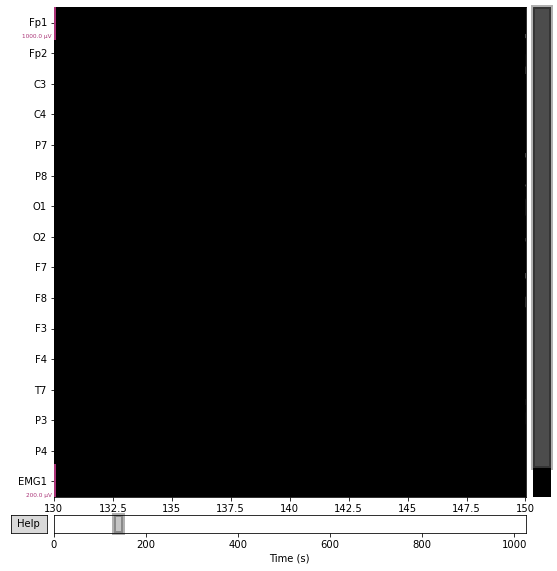

Opening raw-browser...


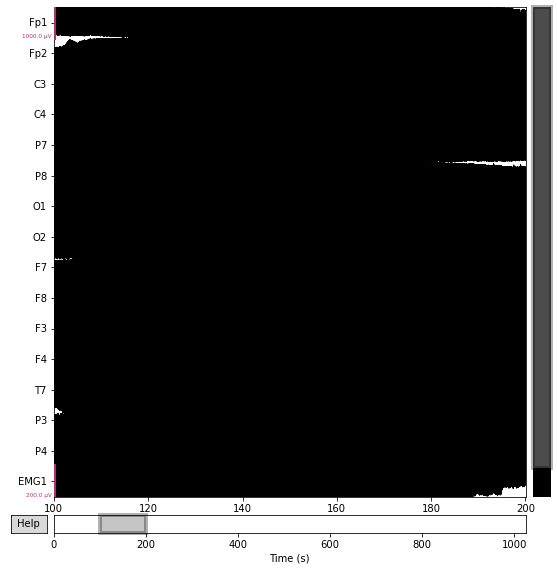

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Opening raw-browser...


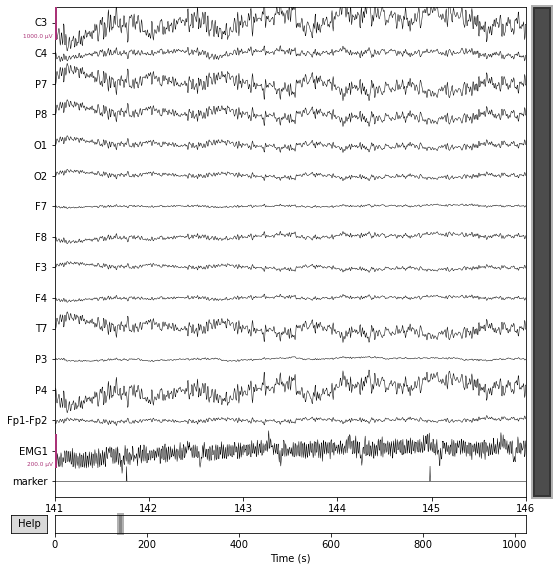

Opening raw-browser...


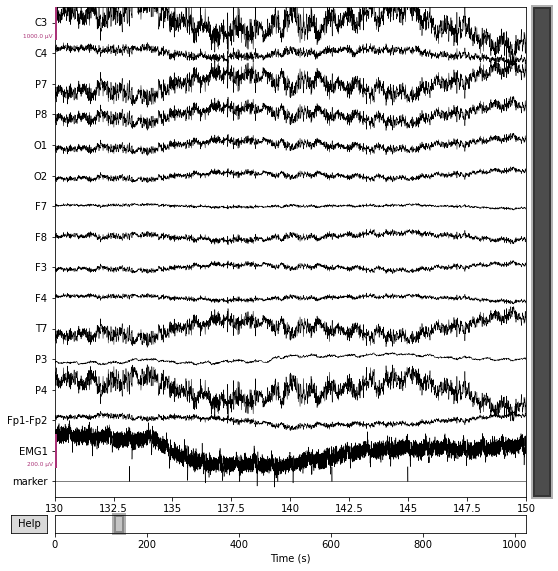

Opening raw-browser...


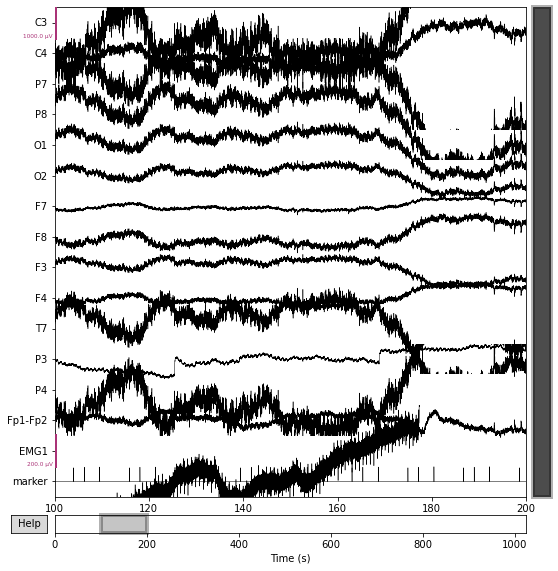

In [19]:
# if we use the average instead

raw_avg_ref = raw_notch_ds.copy().set_eeg_reference(ref_channels='average')
plt = raw_avg_ref.plot(n_channels = 16, start = 141, duration = 5, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')
plt = raw_avg_ref.plot(n_channels = 16, start = 130, duration = 20, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')
plt = raw_avg_ref.plot(n_channels = 16, start = 100, duration = 100, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')

#try from pure raw
raw_avg_ref = raw.copy().set_eeg_reference(ref_channels='average')
plt = raw_avg_ref.plot(n_channels = 16, start = 141, duration = 5, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')
plt = raw_avg_ref.plot(n_channels = 16, start = 130, duration = 20, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')
plt = raw_avg_ref.plot(n_channels = 16, start = 100, duration = 100, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')

#try from reconsstructed
raw_avg_ref = raw_notch_ds_reconst.copy().set_eeg_reference(ref_channels='average')
plt = raw_avg_ref.plot(n_channels = 16, start = 141, duration = 5, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')
plt = raw_avg_ref.plot(n_channels = 16, start = 130, duration = 20, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')
plt = raw_avg_ref.plot(n_channels = 16, start = 100, duration = 100, scalings = dict(eeg = 5e-4, emg = 10e-5), theme = 'dark')